# Get Huggingface pretrained model

In [1]:
!pip install transformers --upgrade --quiet

In [2]:
import transformers
import torch
from transformers import pipeline

## 1. Get pretrained model, test and save it

In [3]:
pretrained_classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [4]:
pretrained_classifier([
    "I really like this place!",
    "The food was bad!"
])

[{'label': 'POSITIVE', 'score': 0.9998599290847778},
 {'label': 'NEGATIVE', 'score': 0.9997907280921936}]

In [5]:
pretrained_classifier.save_pretrained("./model/")

## 2. Check if we can successfully load our saved model

In [6]:
local_classifier = pipeline('sentiment-analysis', model="./model/", tokenizer="./model/")

In [7]:
local_classifier([
    "I really like this place!",
    "The food was bad!"
])

[{'label': 'POSITIVE', 'score': 0.9998599290847778},
 {'label': 'NEGATIVE', 'score': 0.9997907280921936}]

ok this works!

## 3. Build container for Lambda

Let's build a container that holds our huggingface model 
and our lambda code that handles requests and forwards the data to our huggingface model.

In [8]:
print("look at the versions for our dependencies:")
print("")
!python --version
print(f"Torch version {torch.__version__}")
print(f"Transformers version {transformers.__version__}")

look at the versions for our dependencies:

Python 3.6.13
Torch version 1.7.1
Transformers version 4.16.0


#### Create requirements.txt with dependencies

In [9]:
%%writefile requirements.txt
--find-links  https://download.pytorch.org/whl/torch_stable.html 
 
torch==1.7.1+cpu
transformers==4.9.2

Overwriting requirements.txt


#### Create dockerfile
https://docs.aws.amazon.com/lambda/latest/dg/images-create.html

- start from the official lambda docker container.
- copy the requirements.txt to the docker container and isntall.
- copy our model we saved locally in the model/ folder to the docker container
- execcute the lambda handler function on start

In [10]:
%%writefile Dockerfile
FROM public.ecr.aws/lambda/python:3.8

COPY requirements.txt ./requirements.txt
RUN pip install -r requirements.txt 

COPY ./model/   ./model/
COPY ./app/app.py   ./
CMD ["app.handler"]

Overwriting Dockerfile


#### Build dockerfile and push to ECR

In [11]:
!pip install sagemaker-studio-image-build --quiet

make sure this role has a trust relationship with codebuild

https://github.com/aws-samples/sagemaker-studio-image-build-cli

In [13]:
!sm-docker build . --repository huggingface-on-lambda:1.0

...[Container] 2022/01/19 18:00:07 Waiting for agent ping

[Container] 2022/01/19 18:00:08 Waiting for DOWNLOAD_SOURCE
[Container] 2022/01/19 18:00:14 Phase is DOWNLOAD_SOURCE
[Container] 2022/01/19 18:00:14 CODEBUILD_SRC_DIR=/codebuild/output/src038408758/src
[Container] 2022/01/19 18:00:14 YAML location is /codebuild/output/src038408758/src/buildspec.yml
[Container] 2022/01/19 18:00:14 Processing environment variables
[Container] 2022/01/19 18:00:14 No runtime version selected in buildspec.
[Container] 2022/01/19 18:00:15 Moving to directory /codebuild/output/src038408758/src
[Container] 2022/01/19 18:00:15 Configuring ssm agent with target id: codebuild:4ddcd472-c66a-48f7-a824-43e918906fad
[Container] 2022/01/19 18:00:15 Successfully updated ssm agent configuration
[Container] 2022/01/19 18:00:15 Registering with agent
[Container] 2022/01/19 18:00:15 Phases found in YAML: 3
[Container] 2022/01/19 18:00:15  PRE_BUILD: 9 commands
[Container] 2022/01/19 18:00:15  BUILD: 4 commands
[Con

You should consider upgrading via the '/var/lang/bin/python3.8 -m pip install --upgrade pip' command.
Removing intermediate container d7dd9b6db0d7
 ---> 0c9c465b71ef
Step 4/6 : COPY ./model/   ./model/
 ---> abbdbad1b955
Step 5/6 : COPY ./app/app.py   ./
 ---> b3043aa6b0e5
Step 6/6 : CMD ["app.handler"]
 ---> Running in d5a9003eff71
Removing intermediate container d5a9003eff71
 ---> 33e9e0cccb4e
Successfully built 33e9e0cccb4e
Successfully tagged huggingface-on-lambda:1.0

[Container] 2022/01/19 18:01:41 Running command docker tag $IMAGE_REPO_NAME:$IMAGE_TAG $AWS_ACCOUNT_ID.dkr.ecr.$AWS_DEFAULT_REGION.amazonaws.com/$IMAGE_REPO_NAME:$IMAGE_TAG

[Container] 2022/01/19 18:01:41 Phase complete: BUILD State: SUCCEEDED
[Container] 2022/01/19 18:01:41 Phase context status code:  Message:
[Container] 2022/01/19 18:01:41 Entering phase POST_BUILD
[Container] 2022/01/19 18:01:41 Running command echo Build completed on `date`
Build completed on Wed Jan 19 18:01:41 UTC 2022

[Container] 2022/01/19

## 4. Deploy Container within a Lambda Function

Create a serverless.yml file that points to the docker image uri + digest.

We expect a POST request on the path "prediction/"

More configuration can be found in the serverless file ...

In [12]:
ACCOUNT_NUMBER = ""
REGION = ""
# {ACCOUNT_NUMBER}.dkr.ecr.{REGION}.amazonaws.com/huggingface-on-lambda
image_uri= "077590795309.dkr.ecr.eu-west-1.amazonaws.com/huggingface-on-lambda"
# sha256:f0e2ae3aee2cceb6d93d...
image_digest = "sha256:568b5b9008ab99f3ed45dc87d7c0501899db3a8406d69381618d9dd1190d0367"

__serverless file__:

In [13]:
print(f"""
service: huggingface-on-lambda

provider:
  name: aws
  region: eu-west-1 

functions:
  huggingface:
    image: {image_uri}@{image_digest}
    # 2 minutes before we throw a timeout
    timeout: 120
    # have 1 hot lambda available
    provisionedConcurrency: 0
    # our model is less than 1GB, so 1024MB is enough
    memorySize: 1024 
    events:
      - http:
          path: prediction
          method: post

""")


service: huggingface-on-lambda

provider:
  name: aws
  region: eu-west-1 

functions:
  huggingface:
    image: 077590795309.dkr.ecr.eu-west-1.amazonaws.com/huggingface-on-lambda@sha256:568b5b9008ab99f3ed45dc87d7c0501899db3a8406d69381618d9dd1190d0367
    # 2 minutes before we throw a timeout
    timeout: 120
    # have 1 hot lambda available
    provisionedConcurrency: 0
    # our model is less than 1GB, so 1024MB is enough
    memorySize: 1024 
    events:
      - http:
          path: prediction
          method: post




open an AWS cloudshell and install the serverless framework

    npm install serverless

create the serverless.yml file in the cloudshell
    
    cat > serverless.yml

paste the contents and press ctrl + c to close and save the file.
To deploy the stack run

    npm install --prefix ./ serverless
    node_modules/serverless/bin/serverless.js deploy
    
    
            Output:
    
            Serverless: Packaging service...
            Serverless: WARNING: Function huggingface has timeout of 120 seconds, however, 
            it's attached to API Gateway so it's automatically limited to 30 seconds.
            Serverless: Uploading CloudFormation file to S3...
            Serverless: Uploading artifacts...
            Serverless: Validating template...
            Serverless: Updating Stack...
            Serverless: Checking Stack update progress...
            ........................
            Serverless: Stack update finished...
            Service Information
            service: huggingface-on-lambda
            stage: dev
            region: eu-west-1
            stack: huggingface-on-lambda-dev
            resources: 12
            api keys:
              None
            endpoints:
              POST - https://8af9ar02gi.execute-api.eu-west-1.amazonaws.com/dev/prediction
            functions:
              huggingface: huggingface-on-lambda-dev-huggingface
            layers:
              None
            Serverless: Removing old service artifacts from S3...

if deploy succeeds, call the endpoint

    curl -d '{"data":"some very much wow positive text!"}' -H "Content-Type: application/json" -X POST https://8af9ar02gi.execute-api.eu-west-1.amazonaws.com/dev/prediction
            
            Output:
            
            [{"label": "POSITIVE", "score": 0.9998674392700195}]

## 5. Call Endpoint
### First call to a cold Lambda

In [18]:
%%time
!curl -d '{"data":"some very much wow positive text!"}' -H "Content-Type: application/json" -X POST  https://293z5epjvk.execute-api.eu-west-1.amazonaws.com/dev/prediction
    

[{"label": "POSITIVE", "score": 0.9998674392700195}]CPU times: user 4.16 ms, sys: 14 ms, total: 18.1 ms
Wall time: 311 ms


### Burst of 10 000 calls to Lambda

- The min latency is 57 ms, the max is 4651 ms, and the average is 139 ms.
- 0 errors 

In [40]:
%%time
from joblib import Parallel, delayed
def process(i):
    print(".",)
    subprocess.check_call(shlex.split(cmd))
    
results = Parallel(n_jobs=100)(delayed(process)(i) for i in range(10000))

CPU times: user 13.2 s, sys: 1.46 s, total: 14.6 s
Wall time: 1min 3s


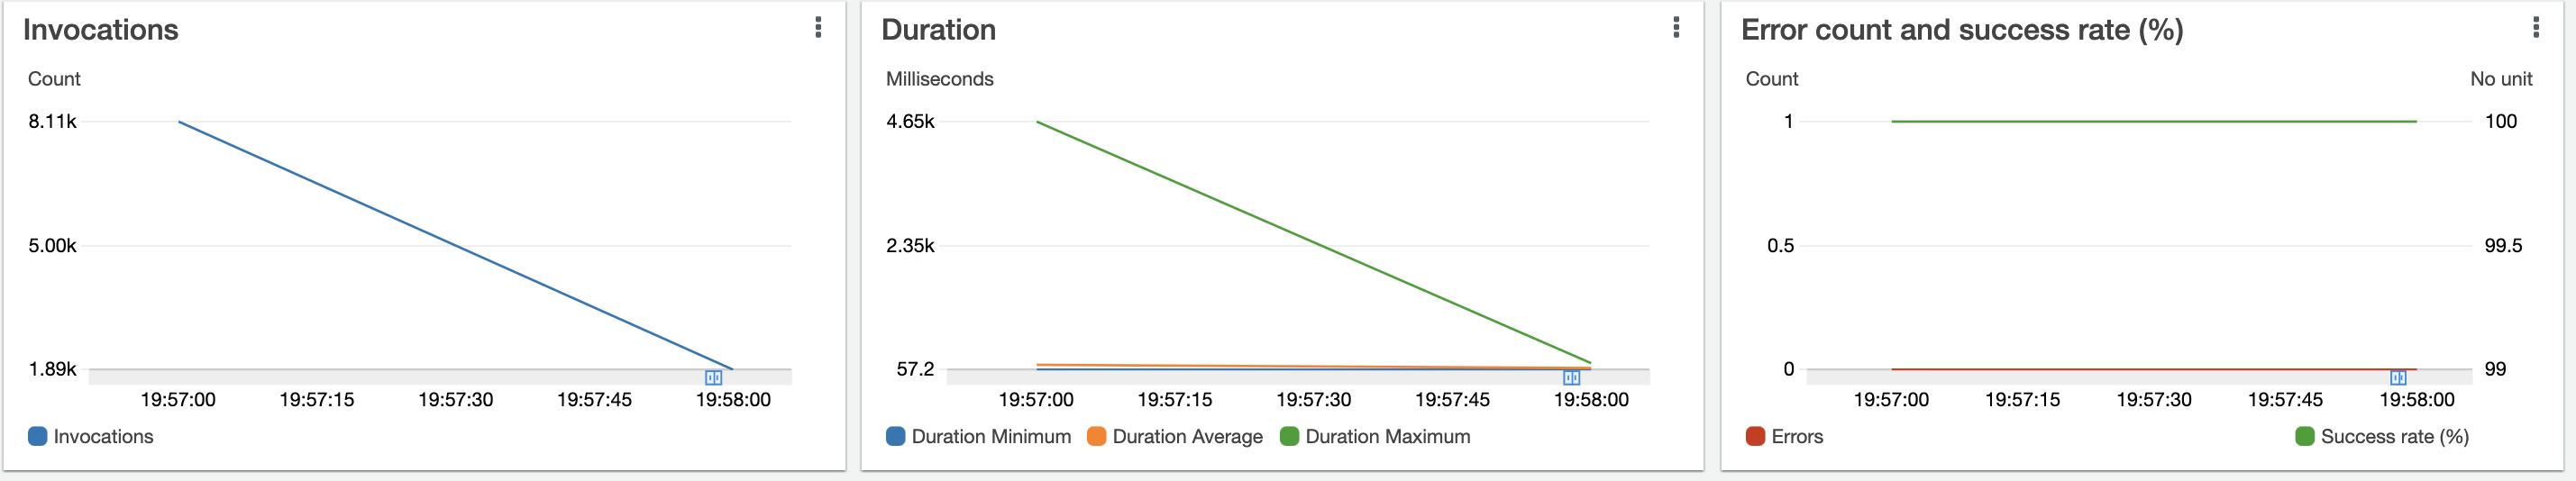

## 6. Remove endpoint